In [115]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import warnings

from scipy import stats
from scipy.optimize import curve_fit
from scipy.stats import betabinom
from scipy.optimize import minimize
from scipy.special import gammaln
warnings.filterwarnings('ignore')

In [122]:
HP200_E1_collisions = pd.read_csv('../Paper/HP200 small E1 collisions.csv')
HP200_E1_collisions.tail()

,Amino Acid Length,Amino Acids on Grid,Shortened Acid Path,Collisions
39995,200,113,LRLLSRSLLRLSRSSLRLLRSLLLLLRRLRRSRRLRLSRSSLRRRS...,87
39996,200,118,SRSLRRSLLRRSLRLRSLRLLSLRRRLSLRSRRLRLRSSRRLRLSS...,82
39997,200,117,SRLRSSRSRRLSLRSRSSLSSLLRRSLLLRRRRLSRLSRRRSLRSR...,83
39998,200,127,SRRSLLSRRLSSLRRRLLSSSLLSLLSRSLRRSRLRSRLLRLRSRR...,73
39999,200,106,RRRLRRLSLRLSLLSLSSLRSRRSRSSRSLRLRLSSLRSRRSLSRS...,94


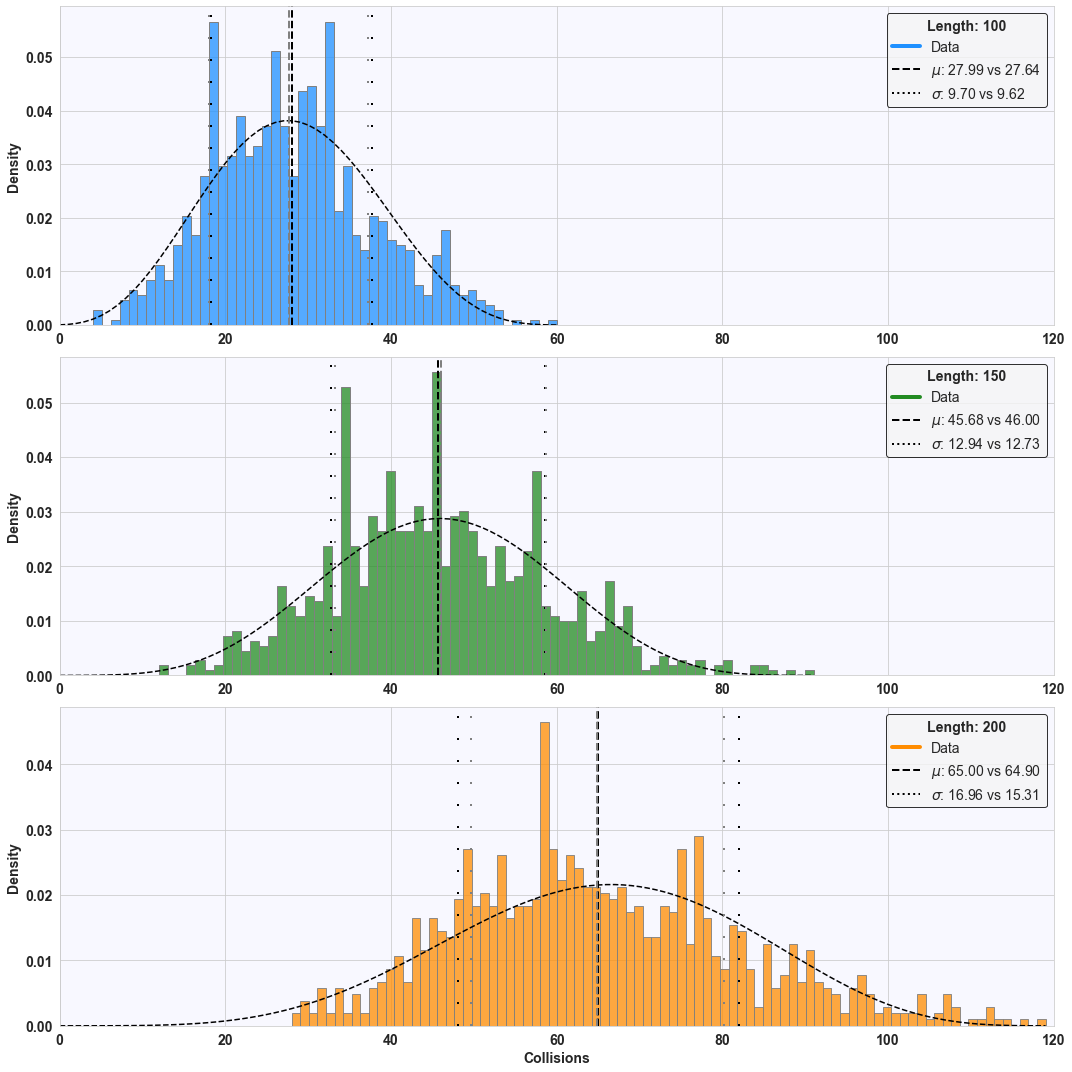

In [124]:
mu_jansen = [27.64, 46.0, 64.9]
sigma_jansen = [9.62, 12.73, 15.31]
lengths = [100,150,200]

colors = {100: 'dodgerblue', 150: 'forestgreen', 200: 'darkorange'}

plt.figure(figsize=(15, 15), facecolor='white')
sns.set_style("whitegrid", {"axes.facecolor": "#F8F8FF"})

for i, length in enumerate([100, 150, 200]):
    ax = plt.subplot(len([100, 150, 200]), 1, i + 1)
    
    # Filter subset for this example; adjust according to your actual data
    subset = HP200_E1_collisions[HP200_E1_collisions['Amino Acid Length'] == length]['Collisions']
    n = max(subset)  # You might need to adjust this based on your data

    mu = subset.mean()
    sigma = subset.std()
    
    # Estimate Beta-Binomial parameters
    a, b = estimate_params(subset, n)
    
    # Calculate PMF for Beta-Binomial fit
    x = np.arange(0, n+1)
    pmf_beta_binomial = betabinom.pmf(x, n, a, b)
    
    # Plot histogram without KDE
    sns.histplot(subset,
                 bins=HP200_E1_collisions[HP200_E1_collisions['Amino Acid Length'] == length]['Collisions'].nunique(),
                 kde=False, color=colors[length], stat='density', edgecolor='grey')
    
    # Estimate Beta-Binomial parameters
    a, b = estimate_params(subset, n)
    
    # Calculate PMF for Beta-Binomial fit
    x = np.arange(0, n+1)
    pmf_beta_binomial = betabinom.pmf(x, n, a, b)
    
    # Overlay Beta-Binomial PMF
    ax.plot(x, pmf_beta_binomial, 'r-', color='black', linestyle='dashed', label='Beta-Binomial Fit')
    
      
    # Add lines for mu, mu + sigma and mu - sigma
    plt.axvline(mu, color='black', linestyle='dashed', linewidth=2)
    plt.axvline(mu + sigma, color='black', linestyle=(0,(1, 10)), linewidth=2)
    plt.axvline(mu - sigma, color='black', linestyle=(0,(1, 10)), linewidth=2)
    
    # Add lines for jansen et al.
    plt.axvline(mu_jansen[i], color='grey', linestyle='dashed', linewidth=2)
    plt.axvline(mu_jansen[i] + sigma_jansen[i], color='grey', linestyle=(0, (1, 10)), linewidth=2)
    plt.axvline(mu_jansen[i] - sigma_jansen[i], color='grey', linestyle=(0, (1, 10)), linewidth=2)
    
    # Update the legend to include Jansen's mu and sigma
    custom_legend = [
        plt.Line2D([0], [0], color=colors[length], lw=4, label='Data'),
        plt.Line2D([0], [0], color='black', linestyle='dashed', lw=2, label=f'$\mu$: {mu:.2f} vs {mu_jansen[i]:.2f}'),
        plt.Line2D([0], [0], color='black', linestyle='dotted', lw=2, label=f'$\sigma$: {sigma:.2f} vs {sigma_jansen[i]:.2f}'),
    ]
    
    # Add the updated legend
    legend = ax.legend(handles=custom_legend, title=f'Length: {length}', fontsize=14, loc='upper right', frameon=True)
    legend.get_frame().set_facecolor('whitesmoke')
    legend.get_frame().set_edgecolor('black')
    plt.setp(legend.get_title(), fontsize=14, fontweight='bold')
    
    # Set the visibility of the axis labels
    if i < len(lengths) - 1:  # If not the last plot, hide the x-axis label
        ax.set_xlabel('')
    else:  # If the last plot, show the x-axis label
        ax.set_xlabel('Collisions', fontsize=14, fontweight='bold')
    
    ax.set_ylabel('')  # Hide the y-axis label for all plots

    plt.xticks(fontsize=14, weight='bold')
    plt.yticks(fontsize=14, weight='bold')  # Hide y-axis ticks
    
    # Standardize X-axis across all plots
    plt.xlim(0, 120)
#     plt.ylim(0, 0.07)
    plt.xticks(np.arange(0, 121, 20))


    if i < len(lengths) - 1:
        ax.set_xlabel('')
    else:
        ax.set_xlabel('Collisions', fontsize=14, fontweight='bold')

    ax.set_ylabel('Density', fontsize=14, fontweight='bold')
    plt.xticks(fontsize=14, weight='bold')
    plt.yticks(fontsize=14, weight='bold')


plt.tight_layout()
plt.savefig("Figure 0.png", format='png', dpi=200)
plt.show()

In [12]:
HP200_E1 = pd.read_csv('../Paper/HP200 small E1.csv')
HP200_E1.tail()

,Amino Acid Length,Amino Acids on Grid,Shortened Acid Path
39995,200,4,LL
39996,200,12,LRSSLRLSLL
39997,200,4,RR
39998,200,16,SRSSSRLLRSSRLL
39999,200,27,SRRLSRLRSSSSSSLLRSLLSRRLL


In [13]:
data = HP200_E1.groupby('Amino Acid Length')['Amino Acids on Grid'].agg(['mean', 'std', 'min', 'max'])
data.rename(columns={'mean': 'Mean', 'std': 'Standard Deviation', 'min': 'Minimum', 'max': 'Maximum'}, inplace=True)

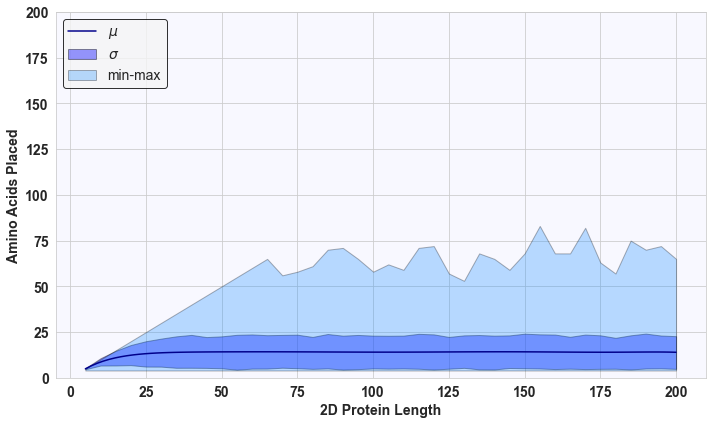

In [14]:
# First, we calculate the required statistics for 'Amino Acids on Grid' per 'Amino Acid Length'
stats = HP200_E1.groupby('Amino Acid Length')['Amino Acids on Grid'].agg(['mean', 'std', 'min', 'max'])

# Fit polynomial regression on the mean values
degree = 8
coeffs_mean = np.polyfit(stats.index, stats['mean'], degree)

# Generate x values for plotting the polynomial curve
x_values = np.linspace(stats.index.min(), stats.index.max(), 100)

# Plotting
plt.figure(figsize=(10, 6),facecolor='white')
sns.set_style("whitegrid", {"axes.facecolor": "#F8F8FF"})

# Plot mean values
# sns.scatterplot(x=stats.index, y=stats['mean'], color='dodgerblue', label='Mean')

# Plot polynomial regression curve for mean values
plt.plot(x_values, np.polyval(coeffs_mean, x_values), color='darkblue', label='$\mu$')

# Add standard deviation as a transparent area around the mean
plt.fill_between(stats.index, stats['mean'] - stats['std'], stats['mean'] + stats['std'], color='blue', alpha=0.4, label='$\sigma$', edgecolor='black')

# Add min-max range as a transparent area
plt.fill_between(stats.index, stats['min'], stats['max'], color='dodgerblue', alpha=0.3, label='min-max', edgecolor='black')


plt.xlabel("2D Protein Length", fontsize=14, fontweight='bold')
plt.ylabel("Amino Acids Placed", fontsize=14, fontweight='bold')
plt.ylim(bottom=0, top=200)  # Set the y-axis range to start from 0
plt.xticks(fontsize=14, weight='bold')
plt.yticks(fontsize=14, weight='bold')

legend = plt.legend(fontsize=14, loc='upper left', frameon=True)
legend.get_frame().set_facecolor('whitesmoke')
legend.get_frame().set_edgecolor('black')

plt.tight_layout()
# plt.savefig("Figure 1.png", format='png', dpi=200)
plt.show()

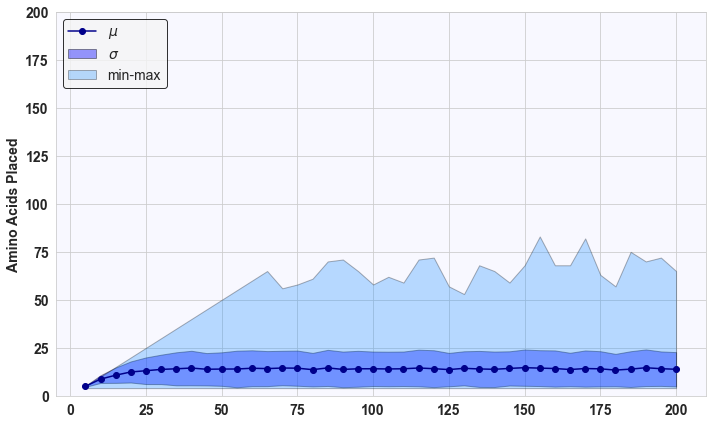

In [15]:
stats = HP200_E1.groupby('Amino Acid Length')['Amino Acids on Grid'].agg(['mean', 'std', 'min', 'max'])

# Plotting adjustments
plt.figure(figsize=(10, 6),facecolor='white')
sns.set_style("whitegrid", {"axes.facecolor": "#F8F8FF"})

# Plot mean values with a straight line
plt.plot(stats.index, stats['mean'], color='darkblue', marker='o', linestyle='-', label='$\mu$')

# Add standard deviation as a transparent area around the mean
plt.fill_between(stats.index, stats['mean'] - stats['std'], stats['mean'] + stats['std'], color='blue', alpha=0.4, label='$\sigma$', edgecolor='black')

# Add min-max range as a transparent area
plt.fill_between(stats.index, stats['min'], stats['max'], color='dodgerblue', alpha=0.3, label='min-max', edgecolor='black')

# plt.xlabel("2D Protein Length", fontsize=14, fontweight='bold')
plt.ylabel("Amino Acids Placed", fontsize=14, fontweight='bold')
plt.ylim(bottom=0, top=200)  # Set the y-axis range to start from 0
plt.xticks(fontsize=14, weight='bold')
plt.yticks(fontsize=14, weight='bold')

legend = plt.legend(fontsize=14, loc='upper left', frameon=True)
legend.get_frame().set_facecolor('whitesmoke')
legend.get_frame().set_edgecolor('black')

plt.tight_layout()
plt.savefig("Figure 1.png", format='png', dpi=200)
plt.show()

In [16]:
HP200_E2 = pd.read_csv('../Paper/HP200 small E2.csv')
HP200_E2.tail()

,Amino Acid Length,Amino Acids on Grid,Shortened Acid Path
39995,200,47,RLRSRSLRRLSSSLLSSRRSSSLLSRSRSLLSSSSLLSRRLRSRR
39996,200,71,SLSLRRSRSLLRLRSSSLSSLSLLRRSSSSSRRLSLRSLRLLRLSR...
39997,200,14,LSLRLRLLSLRL
39998,200,88,SLRSSSLLRLRRLRRLRSSLLRLRLRSRRLLSLSSSSSRLLSRLRR...
39999,200,158,LSSSRLLRRLSLLRSSLRLRRLRSRSSLSSLRSSRLLSSRRLLRSR...


In [17]:
data = HP200_E2.groupby('Amino Acid Length')['Amino Acids on Grid'].agg(['mean', 'std', 'min', 'max'])
data.rename(columns={'mean': 'Mean', 'std': 'Standard Deviation', 'min': 'Minimum', 'max': 'Maximum'}, inplace=True)

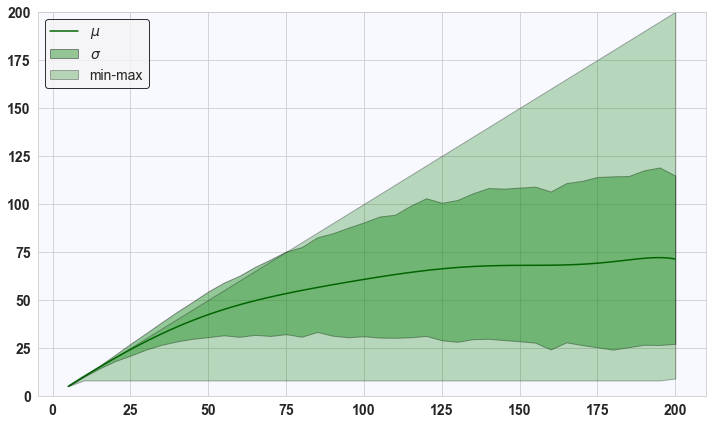

In [18]:
# First, we calculate the required statistics for 'Amino Acids on Grid' per 'Amino Acid Length'
stats = HP200_E2.groupby('Amino Acid Length')['Amino Acids on Grid'].agg(['mean', 'std', 'min', 'max'])

# Fit polynomial regression on the mean values
degree = 8
coeffs_mean = np.polyfit(stats.index, stats['mean'], degree)

# Generate x values for plotting the polynomial curve
x_values = np.linspace(stats.index.min(), stats.index.max(), 100)

# Plotting
plt.figure(figsize=(10, 6),facecolor='white')
sns.set_style("whitegrid", {"axes.facecolor": "#F8F8FF"})
# Plot mean values
# sns.scatterplot(x=stats.index, y=stats['mean'], color='dodgerblue', label='Mean')

# Plot polynomial regression curve for mean values
plt.plot(x_values, np.polyval(coeffs_mean, x_values), color='darkgreen', label='$\mu$')

# Add standard deviation as a transparent area around the mean
plt.fill_between(stats.index, stats['mean'] - stats['std'], stats['mean'] + stats['std'], color='green', alpha=0.4, label='$\sigma$', edgecolor='black')

# Add min-max range as a transparent area
plt.fill_between(stats.index, stats['min'], stats['max'], color='forestgreen', alpha=0.3, label='min-max', edgecolor='black')


# plt.xlabel("2D Protein Length", fontsize=14, fontweight='bold')
# plt.ylabel("Amino Acids Placed", fontsize=14, fontweight='bold')
plt.ylim(bottom=0, top=200)  # Set the y-axis range to start from 0
plt.xticks(fontsize=14, weight='bold')
plt.yticks(fontsize=14, weight='bold')

legend = plt.legend(fontsize=14, loc='upper left', frameon=True)
legend.get_frame().set_facecolor('whitesmoke')
legend.get_frame().set_edgecolor('black')

plt.tight_layout()
# plt.savefig("Figure2.png", format='png', dpi=200)
plt.show()

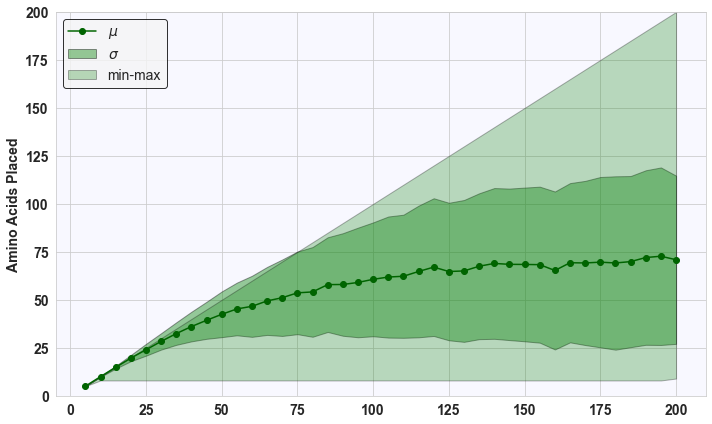

In [19]:
plt.figure(figsize=(10, 6),facecolor='white')
sns.set_style("whitegrid", {"axes.facecolor": "#F8F8FF"})

# Plot mean values with a straight line
plt.plot(stats.index, stats['mean'], color='darkgreen', marker='o', linestyle='-', label='$\mu$')

# Add standard deviation as a transparent area around the mean
plt.fill_between(stats.index, stats['mean'] - stats['std'], stats['mean'] + stats['std'], color='green', alpha=0.4, label='$\sigma$', edgecolor='black')

# Add min-max range as a transparent area
plt.fill_between(stats.index, stats['min'], stats['max'], color='forestgreen', alpha=0.3, label='min-max', edgecolor='black')

# plt.xlabel("2D Protein Length", fontsize=14, fontweight='bold')
plt.ylabel("Amino Acids Placed", fontsize=14, fontweight='bold')
plt.ylim(bottom=0, top=200)  # Set the y-axis range to start from 0
plt.xticks(fontsize=14, weight='bold')
plt.yticks(fontsize=14, weight='bold')

legend = plt.legend(fontsize=14, loc='upper left', frameon=True)
legend.get_frame().set_facecolor('whitesmoke')
legend.get_frame().set_edgecolor('black')

plt.tight_layout()
# plt.savefig("Figure 2.png", format='png', dpi=200)
plt.show()

In [21]:
# Create zero collions df for experiment 1
shapes1 = HP200_E1.groupby(['Amino Acid Length', 'Amino Acids on Grid']).size().reset_index(name='Quantity')
shapes1 = shapes1[(shapes1['Amino Acids on Grid'] % 5 == 0) & (shapes1['Amino Acid Length'] == shapes1['Amino Acids on Grid'])]  # Updated this line
shapes1 = shapes1.drop(columns='Amino Acid Length')
shapes1.head()

# Create zero collions df for experiment 2
shapes2 = HP200_E2.groupby(['Amino Acid Length', 'Amino Acids on Grid']).size().reset_index(name='Quantity')
shapes2 = shapes2[(shapes2['Amino Acids on Grid'] % 5 == 0) & (shapes2['Amino Acid Length'] == shapes2['Amino Acids on Grid'])]  # Updated this line
shapes2 = shapes2.drop(columns='Amino Acid Length')
shapes2.head()

# Merge experimental data
merged_df = pd.merge(shapes1, shapes2, on='Amino Acids on Grid', how='outer', suffixes=(' E1', ' E2'))
merged_df = merged_df.rename(columns={'Amino Acids on Grid': 'Amino Acid Length'})
merged_df = merged_df.fillna(0)

# add synthethical data based on prior work by Jansen et al.
merged_df['Quantity Reitze'] = (2.6024 * np.exp(-0.1294 * merged_df['Amino Acid Length'].values) *1000)
merged_df.head()

,Amino Acid Length,Quantity E1,Quantity E2,Quantity Reitze
0,5,929.0,1000,1362.653765
1,10,627.0,994,713.504950
2,15,357.0,962,373.601371
3,20,210.0,938,195.623007
4,25,136.0,870,102.430997


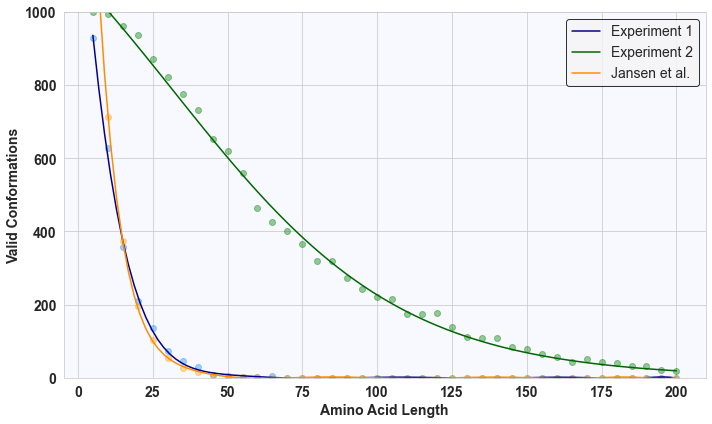

1568.9722370947454 -0.026124731394314923 31.88628252839185


In [110]:
# Define the sigmoid function for fitting
def sigmoid(x, L, k, x0):
    return L / (1 + np.exp(-k * (x - x0)))

# Define an inverse sigmoid-like function for visualization purposes
def inverse_sigmoid(x, L, k, x0):
    # This is not a true mathematical inverse but a visual inversion for illustrative purposes
    return 1000 - (L / (1 + np.exp(-k * (x - x0))))

# Generate x values
x_values = np.linspace(0, 200, 400)

# Calculate y values using the adjusted sigmoid function
y_values = adjusted_sigmoid(x_values)

# Degree of the polynomial fit
degree = 10

# Fit polynomial regression to merged_df for Quantity E1
coeffs_merged_e1 = np.polyfit(merged_df['Amino Acid Length'], merged_df['Quantity E1'], degree)
# Fit polynomial regression to merged_df for Quantity E2
coeffs_merged_e2 = np.polyfit(merged_df['Amino Acid Length'], merged_df['Quantity E2'], degree)
# Fit polynomial regression to merged_df for Quantity Reitze
coeffs_merged_reitze = np.polyfit(merged_df['Amino Acid Length'], merged_df['Quantity Reitze'], degree)

# Generating x values from the range of your data for plotting the polynomial curves
x_values = np.linspace(merged_df['Amino Acid Length'].min(), merged_df['Amino Acid Length'].max(), 100)

# Use the same parameters from a previous fit for demonstration
# For example, using parameters from popt_e2 for an inverse visual representation
L, k, x0 = popt_e2

# Generating x values for plotting
x_values_inverse = np.linspace(merged_df['Amino Acid Length'].min(), merged_df['Amino Acid Length'].max(), 500)

# Plotting
plt.figure(figsize=(10, 6))
sns.set_style("whitegrid", {"axes.facecolor": "#F8F8FF"})

# Plotting merged_df data
plt.scatter(merged_df['Amino Acid Length'], merged_df['Quantity E1'], color='dodgerblue', alpha=0.4)
plt.scatter(merged_df['Amino Acid Length'], merged_df['Quantity E2'], color='green', alpha=0.4 )
plt.scatter(merged_df['Amino Acid Length'], merged_df['Quantity Reitze'], color='orange', alpha=0.4 )

# Plotting the polynomial regression curves
plt.plot(x_values, np.polyval(coeffs_merged_e1, x_values), color='darkblue', linestyle='-', label='Experiment 1')
# Adding the sigmoid and inverse sigmoid plot
plt.plot(x_values, sigmoid(x_values, *popt_e2), color='darkgreen', linestyle='-', label='Experiment 2')
# plt.plot(x_values, np.polyval(coeffs_merged_e2, x_values), color='darkgreen', linestyle='-', label='Experiment 2')
plt.plot(x_values, np.polyval(coeffs_merged_reitze, x_values), color='darkorange', linestyle='-', label='Jansen et al.')



plt.xlabel("Amino Acid Length", fontsize=14, fontweight='bold')
plt.ylabel("Valid Conformations", fontsize=14, fontweight='bold')
plt.ylim(bottom=0)  # Setting the y-axis range to start from 0
plt.xticks(fontsize=14, weight='bold')
plt.yticks(fontsize=14, weight='bold')
plt.ylim(bottom=0, top=1000)  # Setting the y-axis range to start from 0 and go up to 1000

legend = plt.legend(fontsize=14, loc='upper right', frameon=True)
legend.get_frame().set_facecolor('whitesmoke')
legend.get_frame().set_edgecolor('black')

plt.tight_layout()
plt.savefig("Figure 3.png", format='png', dpi=200)
plt.show()
print(L, k, x0)

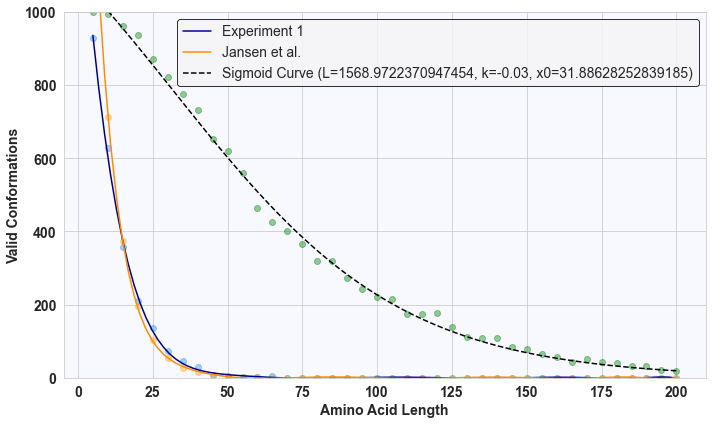

In [98]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Define the sigmoid function for fitting
def sigmoid(x, L, k, x0):
    return L / (1 + np.exp(-k * (x - x0)))

# Assuming 'merged_df' and 'popt_e2' are defined as before
# Define L, k, x0 based on your previous fitting or use example values
L, k, x0 = popt_e2  # Example: popt_e2 might have been obtained from fitting another sigmoid curve

# Degree of the polynomial fit and polynomial regression fits
degree = 10

# Fit polynomial regression to 'merged_df' for various quantities
coeffs_merged_e1 = np.polyfit(merged_df['Amino Acid Length'], merged_df['Quantity E1'], degree)
coeffs_merged_e2 = np.polyfit(merged_df['Amino Acid Length'], merged_df['Quantity E2'], degree)
coeffs_merged_reitze = np.polyfit(merged_df['Amino Acid Length'], merged_df['Quantity Reitze'], degree)

# Generating x values from the range of your data for plotting the polynomial curves
x_values = np.linspace(merged_df['Amino Acid Length'].min(), merged_df['Amino Acid Length'].max(), 100)

# Plotting setup
plt.figure(figsize=(10, 6))
sns.set_style("whitegrid", {"axes.facecolor": "#F8F8FF"})

# Plotting merged_df data
plt.scatter(merged_df['Amino Acid Length'], merged_df['Quantity E1'], color='dodgerblue', alpha=0.4)
plt.scatter(merged_df['Amino Acid Length'], merged_df['Quantity E2'], color='green', alpha=0.4)
plt.scatter(merged_df['Amino Acid Length'], merged_df['Quantity Reitze'], color='orange', alpha=0.4)

# Plotting the polynomial regression curves
plt.plot(x_values, np.polyval(coeffs_merged_e1, x_values), color='darkblue', linestyle='-', label='Experiment 1')
plt.plot(x_values, np.polyval(coeffs_merged_reitze, x_values), color='darkorange', linestyle='-', label='Jansen et al.')

# Adding the enhanced sigmoid plot with parameters in the legend
sigmoid_label = f'Sigmoid Curve (L={L}, k={k:.2f}, x0={x0})'  # Format label to include parameters
plt.plot(x_values, sigmoid(x_values, L+0.1, k, x0), color='black', linestyle='--', label=sigmoid_label)

plt.xlabel("Amino Acid Length", fontsize=14, fontweight='bold')
plt.ylabel("Valid Conformations", fontsize=14, fontweight='bold')
plt.ylim(bottom=0, top=1000)  # Adjust based on your data and preferences
plt.xticks(fontsize=14, weight='bold')
plt.yticks(fontsize=14, weight='bold')

legend = plt.legend(fontsize=14, loc='upper right', frameon=True)
legend.get_frame().set_facecolor('whitesmoke')
legend.get_frame().set_edgecolor('black')

plt.tight_layout()
plt.show()


In [24]:
# convert data to plot P(collisions=0)
probability_df = merged_df.copy()
probability_df[['Quantity E1', 'Quantity E2', 'Quantity Reitze']] /= 1000
merged_df['Quantity Reitze'] = (2.6024 * np.exp(-0.1294 * merged_df['Amino Acid Length'].values) *1000)

probability_df.head()

,Amino Acid Length,Quantity E1,Quantity E2,Quantity Reitze
0,5,0.929,1.000,1.362654
1,10,0.627,0.994,0.713505
2,15,0.357,0.962,0.373601
3,20,0.210,0.938,0.195623
4,25,0.136,0.870,0.102431


<Figure size 720x432 with 0 Axes>

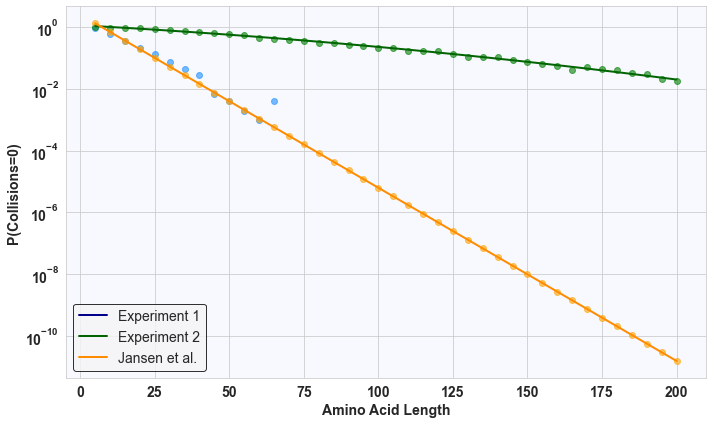

In [26]:
# Data
x = probability_df['Amino Acid Length']
y1 = probability_df['Quantity E1']
y2 = probability_df['Quantity E2']
y3 = probability_df['Quantity Reitze']

# Fit polynomial regression to the data
degree = 2
coeffs1 = np.polyfit(x, np.log(y1), degree)
coeffs2 = np.polyfit(x, np.log(y2), degree)
coeffs3 = np.polyfit(x, np.log(y3), degree)

# Plotting
plt.figure(figsize=(10, 6))
sns.set_style("whitegrid", {"axes.facecolor": "#F8F8FF"})


# Generating x values from the range of your data for plotting the polynomial curves
x_values = np.linspace(x.min(), x.max(), 100)
y_fit1 = np.exp(np.polyval(coeffs1, x_values))
y_fit2 = np.exp(np.polyval(coeffs2, x_values))
y_fit3 = np.exp(np.polyval(coeffs3, x_values))

# Plot data points
plt.figure(figsize=(10, 6))
plt.scatter(x, y1, color='dodgerblue', marker='o', alpha=0.6)
plt.scatter(x, y2, color='green', marker='o', alpha=0.6)
plt.scatter(x, y3, color='orange', marker='o', alpha=0.6)

plt.yscale('log')  # Set the vertical axis to log scale
plt.xlabel("Amino Acid Length", fontsize=14, fontweight='bold')
plt.ylabel("P(Collisions=0)", fontsize=14, fontweight='bold')
plt.xticks(fontsize=14, weight='bold')
plt.yticks(fontsize=14, weight='bold')

# Plot fitted lines
plt.plot(x_values, y_fit1, color='darkblue', linestyle='-', linewidth=2, label='Experiment 1')
plt.plot(x_values, y_fit2, color='darkgreen', linestyle='-', linewidth=2, label='Experiment 2')
plt.plot(x_values, y_fit3, color='darkorange', linestyle='-', linewidth=2, label='Jansen et al.')

legend = plt.legend(fontsize=14, frameon=True)
legend.get_frame().set_facecolor('whitesmoke')
legend.get_frame().set_edgecolor('black')

plt.tight_layout()
plt.show()

In [27]:
# use formulas from papers to create synthetical data
synthetical_df = probability_df.copy()
synthetical_df['Quantity E1'] = (1556.88 * np.exp(-0.10 * merged_df['Amino Acid Length'].values))
synthetical_df['Quantity E2'] = (1227.38 * np.exp(-0.02 * merged_df['Amino Acid Length'].values))
synthetical_df[['Quantity E1', 'Quantity E2']] /= 1000

synthetical_df.head()

,Amino Acid Length,Quantity E1,Quantity E2,Quantity Reitze
0,5,0.944295,1.110579,1.362654
1,10,0.572744,1.004894,0.713505
2,15,0.347387,0.909265,0.373601
3,20,0.210701,0.822737,0.195623
4,25,0.127796,0.744444,0.102431


<Figure size 720x432 with 0 Axes>

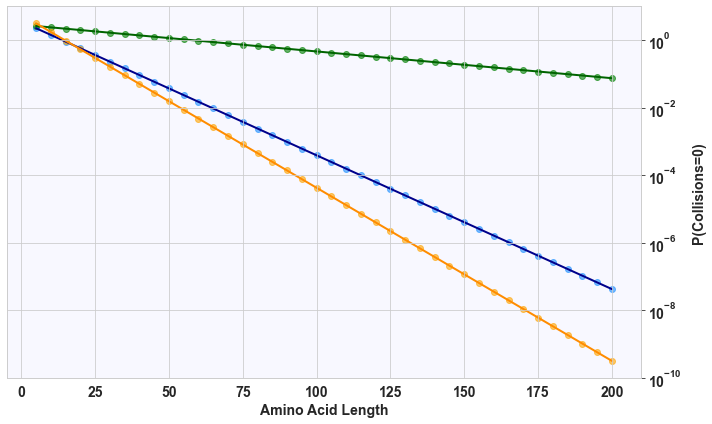

In [74]:
# Data
x = synthetical_df['Amino Acid Length']
y1 = synthetical_df['Quantity E1']
y2 = synthetical_df['Quantity E2']
y3 = synthetical_df['Quantity Reitze']

# Fit polynomial regression to the data
degree = 1
coeffs1 = np.polyfit(x, np.log(y1), degree)
coeffs2 = np.polyfit(x, np.log(y2), degree)
coeffs3 = np.polyfit(x, np.log(y3), degree)

# Plotting
plt.figure(figsize=(10, 6))
sns.set_style("whitegrid", {"axes.facecolor": "#F8F8FF"})

# Generating x values from the range of your data for plotting the polynomial curves
x_values = np.linspace(x.min(), x.max(), 100)
y_fit1 = np.exp(np.polyval(coeffs1, x_values))
y_fit2 = np.exp(np.polyval(coeffs2, x_values))
y_fit3 = np.exp(np.polyval(coeffs3, x_values))

# Plot data points
plt.figure(figsize=(10, 6))
plt.scatter(x, y1, color='dodgerblue', marker='o', alpha=0.6)
plt.scatter(x, y2, color='green', marker='o', alpha=0.6)
plt.scatter(x, y3, color='orange', marker='o', alpha=0.6)

# Plot fitted lines
plt.plot(x_values, y_fit1, color='darkblue', linestyle='-', linewidth=2, label='Experiment 1')
plt.plot(x_values, y_fit2, color='darkgreen', linestyle='-', linewidth=2, label='Experiment 2')
plt.plot(x_values, y_fit3, color='darkorange', linestyle='-', linewidth=2, label='Jansen et al.')

plt.yscale('log')  # Set the vertical axis to log scale
plt.xlabel("Amino Acid Length", fontsize=14, fontweight='bold')
# plt.ylabel("P(Collisions=0)", fontsize=14, fontweight='bold')
plt.xticks(fontsize=14, weight='bold')
plt.yticks(fontsize=14, weight='bold')


# Create a secondary y-axis to the right
ax1 = plt.gca()
ax2 = ax1.twinx()

# legend = plt.legend(fontsize=14, frameon=True)
# legend.get_frame().set_facecolor('whitesmoke')
# legend.get_frame().set_edgecolor('black')

ax2.set_ylabel("P(Collisions=0)", fontsize=14, fontweight='bold', labelpad=10)
ax2.set_yscale('log')
ax2.set_ylim(1e-10, 10)  

# Set tick labels to bold using a loop for both x and y axes
for label in ax1.get_xticklabels():
    label.set_fontweight('bold')
    label.set_fontsize(14)
for label in ax2.get_yticklabels():
    label.set_fontweight('bold')
    label.set_fontsize(14)
    
ax1.set_axisbelow(False)
ax2.set_axisbelow(True)
ax1.yaxis.set_visible(False)


# # Creating a custom legend that includes entries from both axes
# handles = [mean_line, std_fill, minmax_fill]
# labels = ['$\mu$', '$\sigma$', 'min-max']
# # legend = ax1.legend(handles, labels, fontsize=14, loc='upper left', frameon=True)
# legend.get_frame().set_facecolor('whitesmoke')
# legend.get_frame().set_edgecolor('black')

# plt.legend(fontsize=14, frameon=True, loc='best').get_frame().set_facecolor('whitesmoke')
# plt.legend().get_frame().set_edgecolor('black')

plt.tight_layout()
plt.savefig("Figure 4.png", format='png', dpi=200)
plt.show()

In [112]:
from PIL import Image

# Load the images
images = [Image.open(f"Figure {i}.png") for i in range(1, 5)]

# Determine the maximum width and height for the images in each row and column
max_width_col = max(images[0].width, images[2].width), max(images[1].width, images[3].width)
max_height_row = max(images[0].height, images[1].height), max(images[2].height, images[3].height)

# Calculate the total width and height for the combined image
total_width = sum(max_width_col)
total_height = sum(max_height_row)

# Create a new image with the appropriate width and height
combined_image = Image.new('RGB', (total_width, total_height), color='white')

# Paste the individual images into the combined image
x_offsets = [0, max_width_col[0]]  # Starting X positions for columns
y_offsets = [0, max_height_row[0]]  # Starting Y positions for rows

for i, image in enumerate(images):
    x = x_offsets[i % 2]
    y = y_offsets[i // 2]
    combined_image.paste(image, (x, y))

# Save or display the combined image
combined_image.save("Figures 1-4.png")
combined_image.show()

In [121]:
HP200_E2_collisions = pd.read_csv('../Paper/HP200 small E2 collisions.csv')
HP200_E2_collisions.tail()

,Amino Acid Length,Amino Acids on Grid,Shortened Acid Path,Collisions
39995,200,181,RRSLSSLRSRSSSRLSLSSSLRRLSLRLLSSSSLRRSSSRRSLSSS...,19
39996,200,177,LSSLSRRSSLSLSSLLSSLRSSRSLRLLSLRRSRSLRLRSSLRLRS...,23
39997,200,191,LRRLLSLSSRSRSRRSSLRSSSSLLRRSSLRSLLSRSLRSSLSSSS...,9
39998,200,181,SLLSRRLLSRSLSRSSLSRRLSLRSLSRRSSRSLSLSSLSRSLSLL...,19
39999,200,200,LLSRSLSLSLRLRRSSLLSSSRLSLSRRLLSLRSLRSSSRLLSSRR...,0


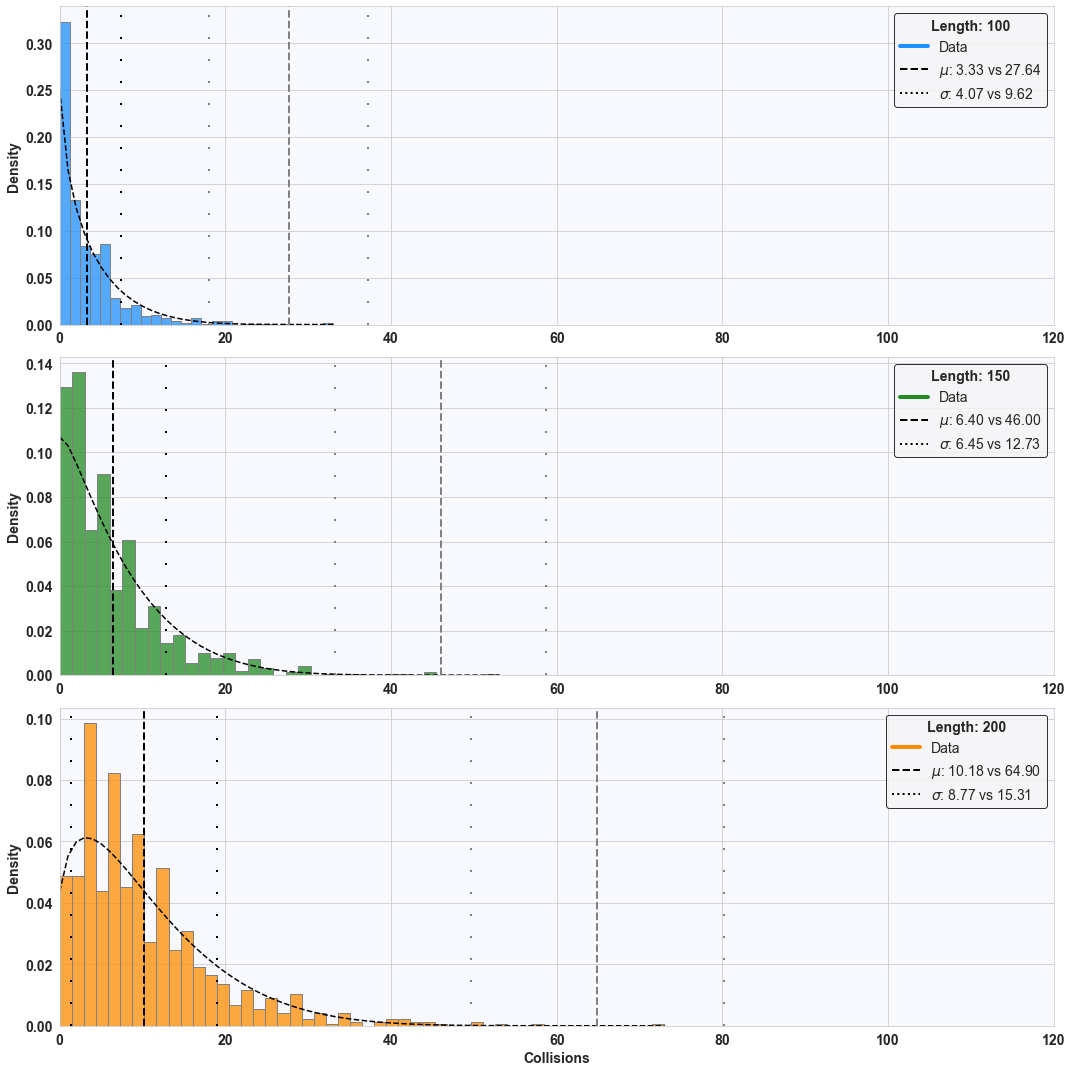

In [125]:
mu_jansen = [27.64, 46.0, 64.9]
sigma_jansen = [9.62, 12.73, 15.31]
lengths = [100,150,200]

colors = {100: 'dodgerblue', 150: 'forestgreen', 200: 'darkorange'}

plt.figure(figsize=(15, 15), facecolor='white')
sns.set_style("whitegrid", {"axes.facecolor": "#F8F8FF"})

for i, length in enumerate([100, 150, 200]):
    ax = plt.subplot(len([100, 150, 200]), 1, i + 1)
    
    # Filter subset for this example; adjust according to your actual data
    subset = HP200_E2_collisions[HP200_E2_collisions['Amino Acid Length'] == length]['Collisions']
    n = max(subset)  # You might need to adjust this based on your data

    mu = subset.mean()
    sigma = subset.std()
    
    # Estimate Beta-Binomial parameters
    a, b = estimate_params(subset, n)
    
    # Calculate PMF for Beta-Binomial fit
    x = np.arange(0, n+1)
    pmf_beta_binomial = betabinom.pmf(x, n, a, b)
    
    # Plot histogram without KDE
    sns.histplot(subset,
                 bins=HP200_E2_collisions[HP200_E2_collisions['Amino Acid Length'] == length]['Collisions'].nunique(),
                 kde=False, color=colors[length], stat='density', edgecolor='grey')
    
    # Estimate Beta-Binomial parameters
    a, b = estimate_params(subset, n)
    
    # Calculate PMF for Beta-Binomial fit
    x = np.arange(0, n+1)
    pmf_beta_binomial = betabinom.pmf(x, n, a, b)
    
    # Overlay Beta-Binomial PMF
    ax.plot(x, pmf_beta_binomial, 'r-', color='black', linestyle='dashed', label='Beta-Binomial Fit')
    
      
    # Add lines for mu, mu + sigma and mu - sigma
    plt.axvline(mu, color='black', linestyle='dashed', linewidth=2)
    plt.axvline(mu + sigma, color='black', linestyle=(0,(1, 10)), linewidth=2)
    plt.axvline(mu - sigma, color='black', linestyle=(0,(1, 10)), linewidth=2)
    
    # Add lines for jansen et al.
    plt.axvline(mu_jansen[i], color='grey', linestyle='dashed', linewidth=2)
    plt.axvline(mu_jansen[i] + sigma_jansen[i], color='grey', linestyle=(0, (1, 10)), linewidth=2)
    plt.axvline(mu_jansen[i] - sigma_jansen[i], color='grey', linestyle=(0, (1, 10)), linewidth=2)
    
    # Update the legend to include Jansen's mu and sigma
    custom_legend = [
        plt.Line2D([0], [0], color=colors[length], lw=4, label='Data'),
        plt.Line2D([0], [0], color='black', linestyle='dashed', lw=2, label=f'$\mu$: {mu:.2f} vs {mu_jansen[i]:.2f}'),
        plt.Line2D([0], [0], color='black', linestyle='dotted', lw=2, label=f'$\sigma$: {sigma:.2f} vs {sigma_jansen[i]:.2f}'),
    ]
    
    # Add the updated legend
    legend = ax.legend(handles=custom_legend, title=f'Length: {length}', fontsize=14, loc='upper right', frameon=True)
    legend.get_frame().set_facecolor('whitesmoke')
    legend.get_frame().set_edgecolor('black')
    plt.setp(legend.get_title(), fontsize=14, fontweight='bold')
    
    # Set the visibility of the axis labels
    if i < len(lengths) - 1:  # If not the last plot, hide the x-axis label
        ax.set_xlabel('')
    else:  # If the last plot, show the x-axis label
        ax.set_xlabel('Collisions', fontsize=14, fontweight='bold')
    
    ax.set_ylabel('')  # Hide the y-axis label for all plots

    plt.xticks(fontsize=14, weight='bold')
    plt.yticks(fontsize=14, weight='bold')  # Hide y-axis ticks
    
    # Standardize X-axis across all plots
    plt.xlim(0, 120)
#     plt.ylim(0, 0.07)
    plt.xticks(np.arange(0, 121, 20))


    if i < len(lengths) - 1:
        ax.set_xlabel('')
    else:
        ax.set_xlabel('Collisions', fontsize=14, fontweight='bold')

    ax.set_ylabel('Density', fontsize=14, fontweight='bold')
    plt.xticks(fontsize=14, weight='bold')
    plt.yticks(fontsize=14, weight='bold')


plt.tight_layout()
plt.savefig("Figure 00.png", format='png', dpi=200)
plt.show()